In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, r2_score, mean_absolute_error, classification_report, plot_confusion_matrix, accuracy_score
from scipy.stats import reciprocal, randint
from sklearn.linear_model import LinearRegression,  Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

# Exploración

In [2]:
df = pd.read_csv('winequality-red.csv', sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df.quality.value_counts(sort=False)

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [4]:
X = df.drop(columns='quality')
sc = StandardScaler()
X = sc.fit_transform(X)
y = df.quality

In [5]:
y_list = [['Calidad con todos los valores', y],
          ['Calidad con 2 clases', pd.cut(y, bins=[0, 5.5, 10], labels=[0, 1])],
          ['Calidad con 3 clases uniforme', pd.cut(y, bins=[0, 4.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 3 clases no uniforme', pd.cut(y, bins=[0, 5.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 4 clases', pd.cut(y, bins=[0, 4.5, 5.5, 6.5, 10], labels=[0, 1, 2, 3])]
         ]

In [6]:
#Función para determinar y graficar las variables independientes mas importantes
def plot_feature_importances(clf, X_train, y_train=None, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    clf.fit(X_train, y_train)
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

# Modelos simples

## Regresión Logística

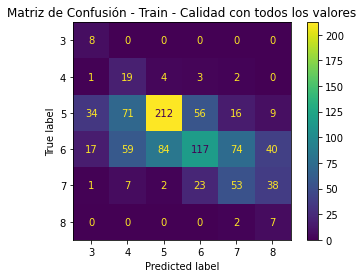

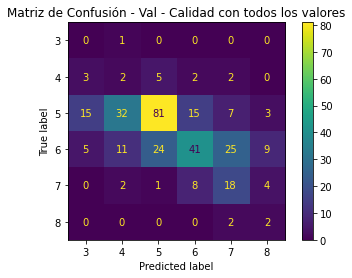

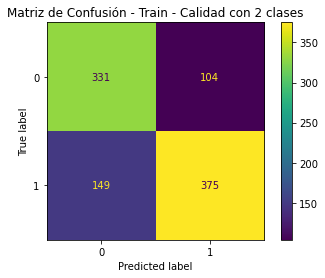

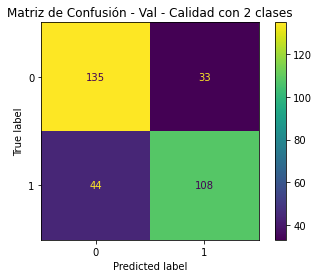

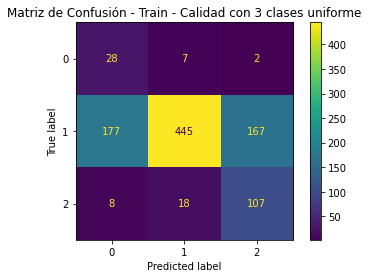

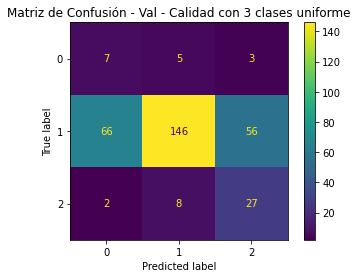

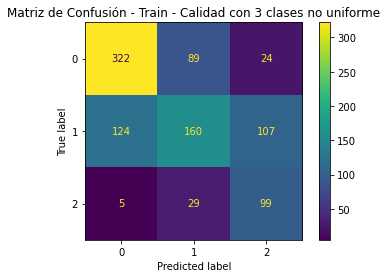

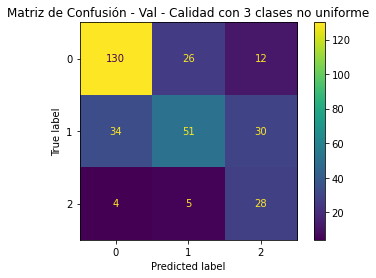

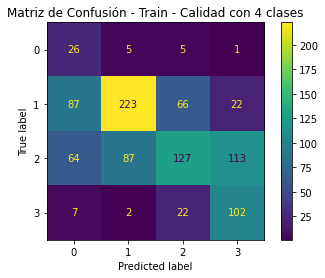

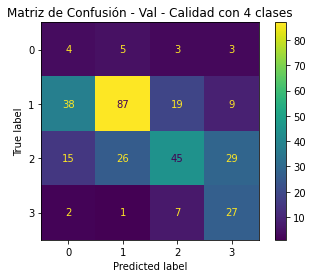

Wall time: 2min 28s


In [7]:
%%time
list_lr = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    log_est = LogisticRegression(class_weight='balanced', 
                                                multi_class='multinomial',
                                                solver='newton-cg',
                                                fit_intercept=True, 
                                                penalty='l2',
                                                max_iter=500)

    dists = {'C': reciprocal(1e-4, 1e4)}

    lr = RandomizedSearchCV(log_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    lr.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(lr, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(lr, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_lr.append([Y[0], 
                   f1_score(y_train, lr.predict(X_train), average='macro'),
                   f1_score(y_val, lr.predict(X_val), average='macro'),
                   accuracy_score(y_train, lr.predict(X_train)),
                   accuracy_score(y_test, lr.predict(X_test)),
                   f1_score(y_train, lr.predict(X_train), average=None),
                   f1_score(y_test, lr.predict(X_test), average=None)]
                  )

In [8]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:,.4f}'.format
labels_metrics = ['Variables', 'F1 Score Train', 'F1 Score Val','Accuracy Train','Accuracy Test','F1 Train Scores for each class', 'F1 Test Scores for each class']
df_metrics_lr = pd.DataFrame(list_lr, columns=labels_metrics)
df_metrics_lr

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.3278,0.2878,0.4338,0.4125,"[0.23188405797101452, 0.20540540540540542, 0.6057142857142858, 0.39661016949152544, 0.3911439114...","[0.0, 0.11111111111111109, 0.5897435897435898, 0.38775510204081637, 0.40860215053763443, 0.16216..."
1,Calidad con 2 clases,0.7356,0.7576,0.7362,0.7312,"[0.7234972677595628, 0.7477567298105683]","[0.7189542483660131, 0.7425149700598802]"
2,Calidad con 3 clases uniforme,0.4847,0.4261,0.6048,0.6438,"[0.224, 0.7069102462271645, 0.5232273838630807]","[0.26829268292682923, 0.7363420427553444, 0.583941605839416]"
3,Calidad con 3 clases no uniforme,0.5835,0.6050,0.6058,0.5875,"[0.7268623024830699, 0.47832585949177875, 0.5454545454545455]","[0.7235494880546075, 0.43317972350230416, 0.5384615384615385]"
4,Calidad con 4 clases,0.4562,0.4346,0.4984,0.4906,"[0.23529411764705882, 0.6237762237762239, 0.4157119476268412, 0.549865229110512]","[0.23529411764705882, 0.5916666666666667, 0.41747572815533973, 0.5555555555555555]"


## Máquina de Soporte Vecotrial (SVM)

{'C': 209.58659734249005, 'gamma': 0.011624800554939075}


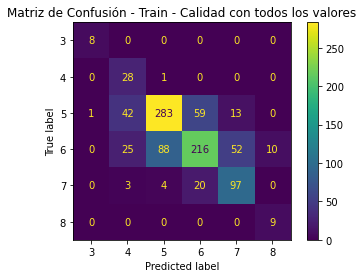

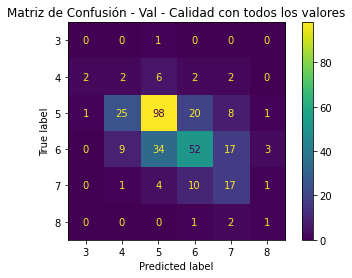

{'C': 1.3719922139057792, 'gamma': 0.12245311484412665}


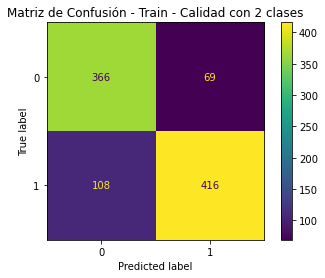

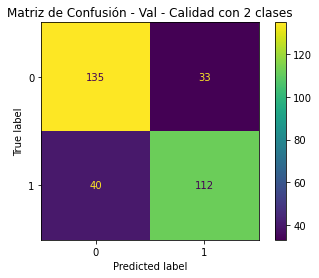

{'C': 35.088119867116, 'gamma': 0.029195323947312234}


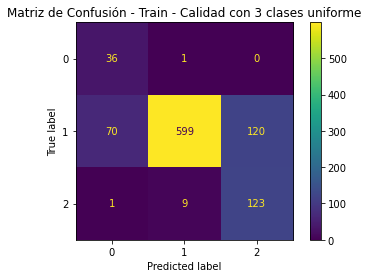

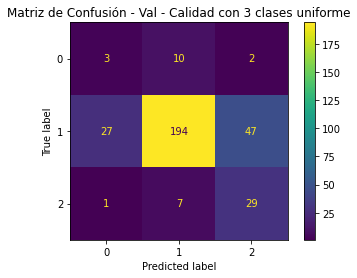

{'C': 4.371217617733168, 'gamma': 0.43049964165369076}


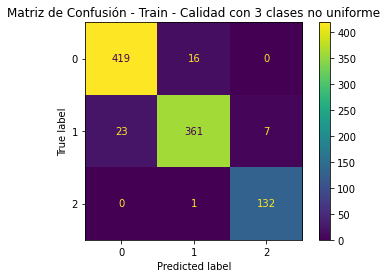

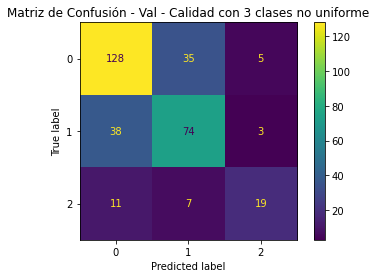

{'C': 13.148105511729243, 'gamma': 0.04563188049437045}


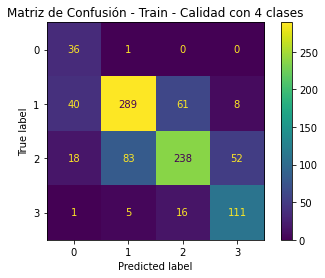

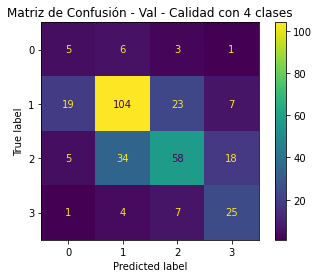

Wall time: 3min 35s


In [9]:
%%time
list_svm = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_est = SVC(kernel='rbf', class_weight='balanced')

    dists = {'gamma':reciprocal(0.01, 100),'C': reciprocal(1e-4, 1e4)}

    svm = RandomizedSearchCV(svm_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    svm.fit(X_train, y_train)
    print(svm.best_params_)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm.append([Y[0], 
                   f1_score(y_train, svm.predict(X_train), average='macro'),
                   f1_score(y_val, svm.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm.predict(X_train)),
                   accuracy_score(y_test, svm.predict(X_test)),
                   f1_score(y_train, svm.predict(X_train), average=None),
                   f1_score(y_test, svm.predict(X_test), average=None)]
                   )

In [10]:
df_metrics_svm = pd.DataFrame(list_svm, columns=labels_metrics)
df_metrics_svm

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.6774,0.3152,0.6684,0.5281,"[0.9411764705882353, 0.4409448818897638, 0.731266149870801, 0.6297376093294461, 0.67832167832167...","[0.0, 0.25531914893617025, 0.634920634920635, 0.5344827586206896, 0.4565217391304348, 0.0]"
1,Calidad con 2 clases,0.8149,0.7707,0.8154,0.7625,"[0.8052805280528053, 0.8245787908820613]","[0.7432432432432433, 0.7790697674418605]"
2,Calidad con 3 clases uniforme,0.6704,0.4816,0.7904,0.7281,"[0.5, 0.8569384835479256, 0.6542553191489362]","[0.34782608695652173, 0.8104575163398692, 0.5777777777777778]"
3,Calidad con 3 clases no uniforme,0.9550,0.6588,0.9510,0.6562,"[0.9555302166476625, 0.9388816644993497, 0.9705882352941175]","[0.7247386759581882, 0.6044776119402985, 0.5882352941176471]"
4,Calidad con 4 clases,0.6737,0.5111,0.7028,0.5875,"[0.5454545454545455, 0.7448453608247423, 0.6742209631728046, 0.730263157894737]","[0.3255813953488372, 0.6692913385826771, 0.5523012552301255, 0.5769230769230769]"


## Árbol de Decisión

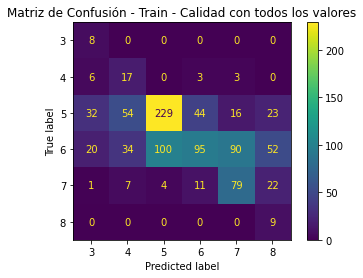

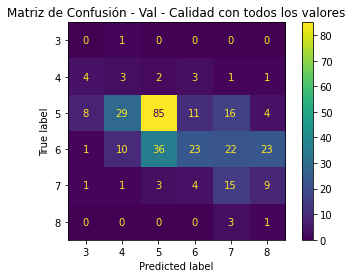

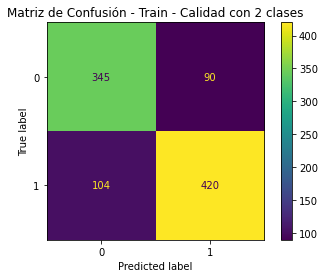

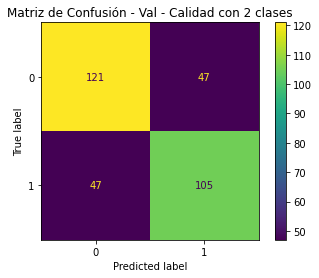

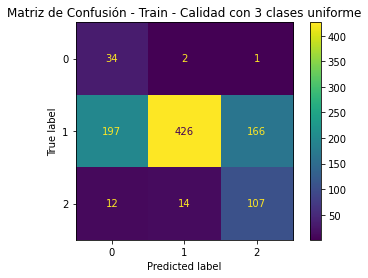

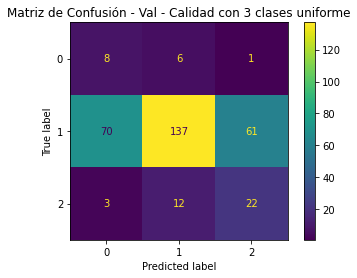

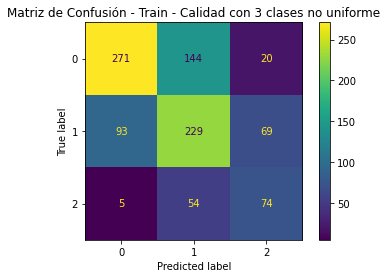

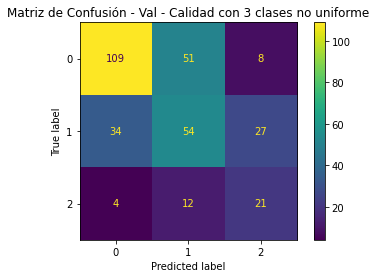

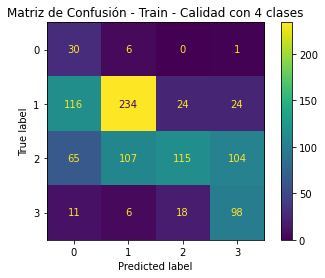

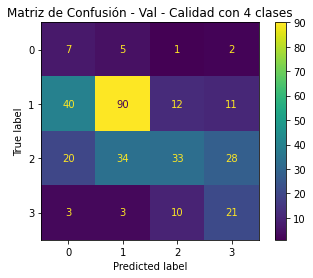

Wall time: 24.3 s


In [11]:
%%time
list_tree = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    tree_est = DecisionTreeClassifier(class_weight='balanced')

    dists = {'max_depth':range(2, 100),'min_samples_leaf': range(10, 1000)}

    tree = RandomizedSearchCV(tree_est, param_distributions = dists, n_iter=200, scoring='f1_macro')

    tree.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(tree, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(tree, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_tree.append([Y[0], 
                   f1_score(y_train, tree.predict(X_train), average='macro'),
                   f1_score(y_val, tree.predict(X_val), average='macro'),
                   accuracy_score(y_train, tree.predict(X_train)),
                   accuracy_score(y_test, tree.predict(X_test)),
                   f1_score(y_train, tree.predict(X_train), average=None),
                   f1_score(y_test, tree.predict(X_test), average=None)]
                   )

In [12]:
df_metrics_tree = pd.DataFrame(list_tree, columns=labels_metrics)
df_metrics_tree

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.3489,0.2314,0.4557,0.3625,"[0.21333333333333335, 0.2411347517730496, 0.6265389876880986, 0.3492647058823529, 0.506410256410...","[0.0, 0.07692307692307693, 0.5541125541125541, 0.28571428571428564, 0.4067796610169492, 0.0]"
1,Calidad con 2 clases,0.7965,0.7055,0.7977,0.7344,"[0.7805429864253394, 0.8123791102514506]","[0.7098976109215016, 0.755043227665706]"
2,Calidad con 3 clases uniforme,0.4869,0.3927,0.5912,0.5156,"[0.24285714285714288, 0.6921202274573517, 0.5257985257985258]","[0.10752688172043011, 0.6287128712871287, 0.46153846153846156]"
3,Calidad con 3 clases no uniforme,0.5780,0.5364,0.5985,0.5875,"[0.6741293532338308, 0.5599022004889975, 0.5]","[0.6765799256505576, 0.5207547169811321, 0.5283018867924528]"
4,Calidad con 4 clases,0.4547,0.4016,0.4974,0.4156,"[0.23166023166023167, 0.6231691078561917, 0.41970802919708033, 0.5444444444444445]","[0.11494252873563217, 0.6122448979591837, 0.23863636363636362, 0.48484848484848475]"


# Métodos de Ensamble

## Random Forest

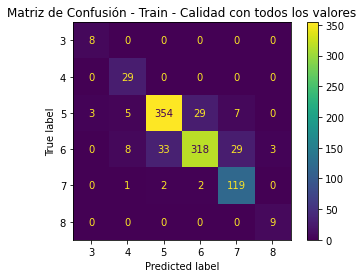

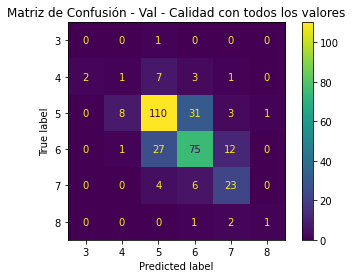

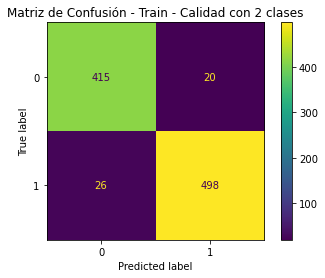

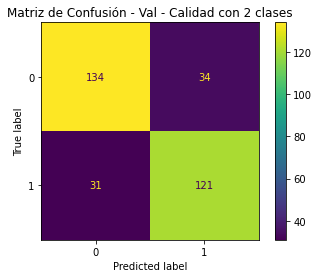

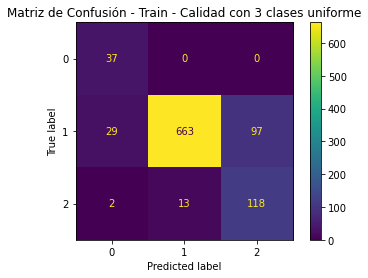

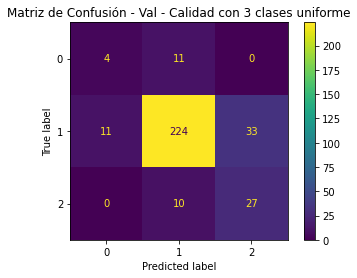

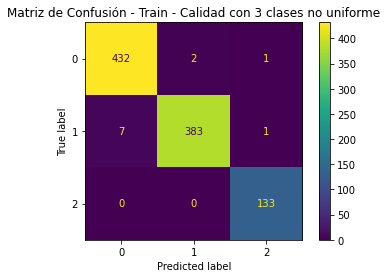

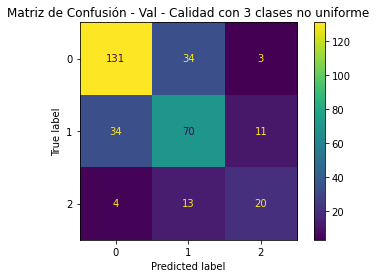

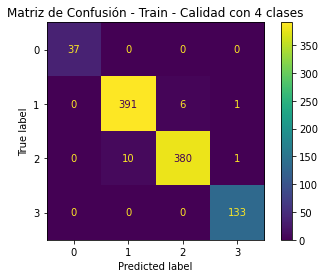

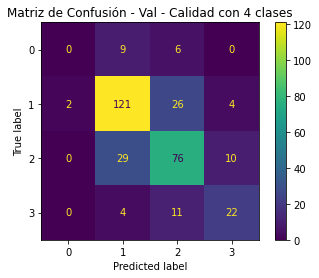

Wall time: 5min 46s


In [13]:
%%time
list_forest = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    forest_est = RandomForestClassifier(class_weight='balanced')

    dists = {'n_estimators':range(20, 100), 'max_depth':(2, 50), 'min_samples_leaf':range(2, 50)}
    
    forest = RandomizedSearchCV(forest_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    forest.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(forest, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(forest, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_forest.append([Y[0], 
                   f1_score(y_train, forest.predict(X_train), average='macro'),
                   f1_score(y_val, forest.predict(X_val), average='macro'),
                   accuracy_score(y_train, forest.predict(X_train)),
                   accuracy_score(y_test, forest.predict(X_test)),
                   f1_score(y_train, forest.predict(X_train), average=None),
                   f1_score(y_test, forest.predict(X_test), average=None)]
                   )

In [14]:
df_metrics_forest = pd.DataFrame(list_forest, columns=labels_metrics)
df_metrics_forest

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.8528,0.4027,0.8728,0.5906,"[0.8421052631578948, 0.8055555555555556, 0.8996188055908512, 0.8594594594594595, 0.8530465949820...","[0.0, 0.25, 0.6831275720164609, 0.5977011494252873, 0.48543689320388356, 0.0]"
1,Calidad con 2 clases,0.9517,0.7965,0.9520,0.7812,"[0.9474885844748858, 0.9558541266794626]","[0.75, 0.8055555555555556]"
2,Calidad con 3 clases uniforme,0.7627,0.5656,0.8530,0.7562,"[0.7047619047619048, 0.9051194539249147, 0.67816091954023]","[0.27586206896551724, 0.8395061728395061, 0.5439999999999999]"
3,Calidad con 3 clases no uniforme,0.9894,0.6481,0.9885,0.6750,"[0.9885583524027459, 0.9871134020618557, 0.9925373134328358]","[0.762589928057554, 0.63003663003663, 0.5393258426966292]"
4,Calidad con 4 clases,0.9873,0.5045,0.9812,0.6375,"[1.0, 0.9787234042553192, 0.9781209781209782, 0.9925373134328358]","[0.0, 0.7203065134099618, 0.6209386281588448, 0.5333333333333333]"


## Bagging de SVM

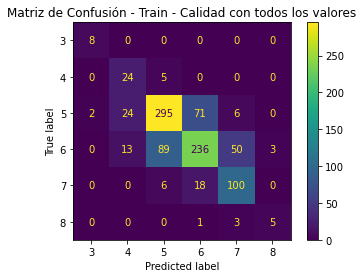

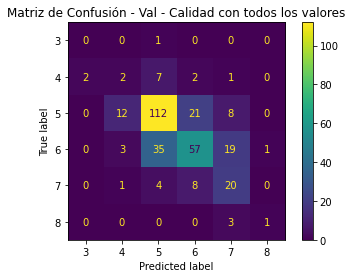

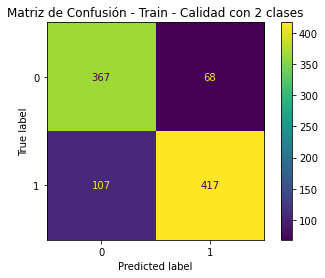

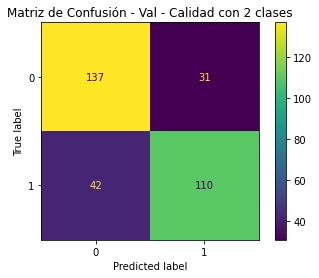

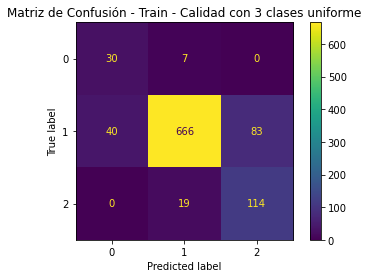

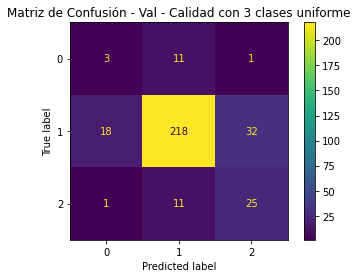

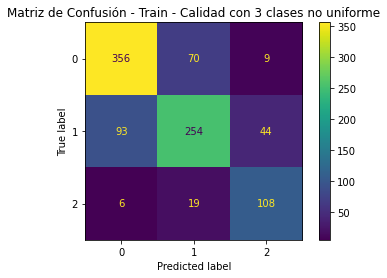

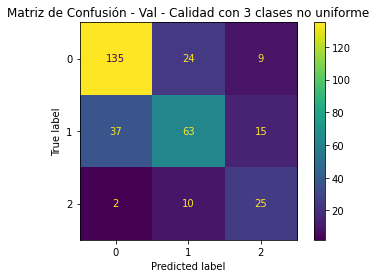

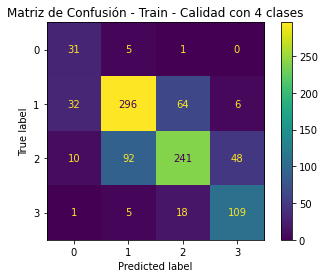

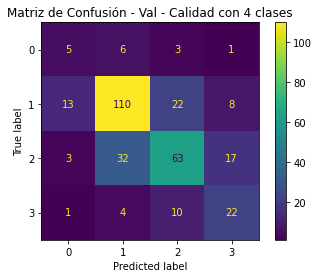

Wall time: 28min 50s


In [16]:
%%time
list_svm_bag = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_bag_est = BaggingClassifier(base_estimator=SVC(kernel='rbf', C=10, gamma=0.05, class_weight='balanced'), max_samples=2/3)

    dists = {'n_estimators':range(20, 100)}
    
    svm_bag = GridSearchCV(svm_bag_est, param_grid = dists, scoring='f1_macro')

    svm_bag.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm_bag, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm_bag, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm_bag.append([Y[0], 
                   f1_score(y_train, svm_bag.predict(X_train), average='macro'),
                   f1_score(y_val, svm_bag.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm_bag.predict(X_train)),
                   accuracy_score(y_test, svm_bag.predict(X_test)),
                   f1_score(y_train, svm_bag.predict(X_train), average=None),
                   f1_score(y_test, svm_bag.predict(X_test), average=None)]
                   )

In [18]:
df_metrics_svm_bag = pd.DataFrame(list_svm_bag, columns=labels_metrics)
df_metrics_svm_bag

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.6866,0.3690,0.6966,0.5625,"[0.888888888888889, 0.5333333333333333, 0.7440100882723832, 0.6582984658298466, 0.70671378091872...","[0.0, 0.24242424242424243, 0.6564885496183206, 0.5416666666666666, 0.5208333333333334, 0.0]"
1,Calidad con 2 clases,0.8170,0.7702,0.8175,0.7625,"[0.8074807480748075, 0.8265609514370665]","[0.7466666666666666, 0.776470588235294]"
2,Calidad con 3 clases uniforme,0.7170,0.5156,0.8446,0.8031,"[0.5607476635514019, 0.8993923024983119, 0.6909090909090909]","[0.2962962962962963, 0.8742514970059879, 0.6071428571428572]"
3,Calidad con 3 clases no uniforme,0.7423,0.6551,0.7487,0.6531,"[0.8, 0.6920980926430518, 0.7346938775510204]","[0.7397260273972602, 0.5714285714285713, 0.6041666666666666]"
4,Calidad con 4 clases,0.6782,0.5252,0.7059,0.5875,"[0.5585585585585585, 0.7437185929648241, 0.6741258741258741, 0.7364864864864865]","[0.37499999999999994, 0.6691729323308271, 0.5311203319502075, 0.5742574257425743]"
